### This notebook generates the CAPE-omega relationships for MCSs in the idealized RCE simulations. First import libraries and constants.

In [1]:
import numpy as np
from scipy import stats
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import cm
import random

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# colorblind friendly colormap
CB_color_cycle = [ '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3',
                   '#999999', '#e41a1c', '#dede00']

## Loading RCE data

In [2]:
#path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/'
path = '/xdisk/sylvia/RCE-CAPE-exploration/'
ssts = np.arange( 285, 315, 5 )

mean_285 = xr.open_dataset( path + 'RCE_COL_MEAN_285.nc' )
mean_290 = xr.open_dataset( path + 'RCE_COL_MEAN_290.nc' )
mean_295 = xr.open_dataset( path + 'RCE_COL_MEAN_295.nc' )
mean_300 = xr.open_dataset( path + 'RCE_COL_MEAN_300.nc' )
mean_305 = xr.open_dataset( path + 'RCE_COL_MEAN_305.nc' )
mean_310 = xr.open_dataset( path + 'RCE_COL_MEAN_310.nc' )

#p95_285 = xr.open_dataset( path + 'RCE_COL_95_285.nc' )
#p95_290 = xr.open_dataset( path + 'RCE_COL_95_290.nc' )
#p95_295 = xr.open_dataset( path + 'RCE_COL_95_295.nc' )
#p95_300 = xr.open_dataset( path + 'RCE_COL_95_300.nc' )
#p95_305 = xr.open_dataset( path + 'RCE_COL_95_305.nc' )
#p95_310 = xr.open_dataset( path + 'RCE_COL_95_310.nc' )

clusters_285 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_285.nc' )
clusters_290 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_290.nc' )
clusters_295 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_295.nc' )
clusters_300 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_300.nc' )
clusters_305 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_305.nc' )
clusters_310 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_310.nc' )

In [3]:
# Verifying that 17 is the index closest to 550 hPa
for i in np.arange(10):
    n = random.randint( 0, mean_295['ascent'].shape[1] )
    print( mean_295['p'][n,17].values )
    
print( mean_295['ascent'].shape )
print( np.nanmax(mean_295['ascent'][:,17]), np.nanmean(mean_295['ascent']), np.nanmin(mean_295['ascent'][:,18]) )
#print( np.nanmax(p99_295['ascent'][:,17]), np.nanmean(p99_295['ascent']), np.nanmin(p99_295['ascent'][:,18]) )

547.5784
547.2411
547.37585
547.2411
547.53735
547.04395
547.2744
547.27594
547.5099
547.2814
(590, 64)
19.350323 3.8182948 3.180078


In [4]:
pc2 = 99
nbin = 40
mean_RCE = [ mean_285, mean_290, mean_295, mean_300, mean_305, mean_310 ]
cape_bins_list = [ [] for i in mean_RCE ]
ascent_list = [ [] for i in mean_RCE ]
ascent_99_list = [ [] for i in mean_RCE ]
ascent_error_list = [ [] for i in mean_RCE ]
for iterator, array in enumerate( mean_RCE ):
    cape_RCE = array['CAPE'].to_numpy()
    ascent_RCE = array['ascent'][:,17].to_numpy()  # ascent rates at 550 hPa 

    cape_bins, ascent_vals, _, ascent_99_vals, _, ascent_error, _, _ = \
        bin_stat_function( nbin, np.nanmin(cape_RCE), np.nanmax(cape_RCE), cape_RCE, ascent_RCE, pc2=pc2, threshold=20 ) #20000 as upper bound for max_RCE
    
    cape_bins_list[iterator] = cape_bins
    ascent_list[iterator] = ascent_vals
    ascent_99_list[iterator] = ascent_99_vals
    ascent_error_list[iterator] = ascent_error

In [5]:
clusters = [ clusters_285, clusters_290, clusters_295, clusters_300, clusters_305, clusters_310 ]
rad = []
for c in clusters:
    rad.append( 2*(c['cluster_sizes']*9/np.pi)**(0.5) )
    
cape_RCE = np.concatenate( (mean_285['CAPE'].to_numpy(), mean_290['CAPE'].to_numpy(), mean_295['CAPE'].to_numpy(),
                                mean_300['CAPE']. to_numpy(), mean_305['CAPE'].to_numpy(), mean_310['CAPE'].to_numpy()), axis=0 )
omega_RCE = np.concatenate( (mean_285['ascent'][:,17].to_numpy(), mean_290['ascent'][:,17].to_numpy(), mean_295['ascent'][:,17].to_numpy(),
                                mean_300['ascent'][:,17]. to_numpy(), mean_305['ascent'][:,17].to_numpy(),
                                mean_310['ascent'][:,17].to_numpy()), axis=0 )
rad_RCE = np.concatenate( (rad[0].to_numpy(), rad[1].to_numpy(), rad[2].to_numpy(), rad[3].to_numpy(), rad[4].to_numpy(),
                          rad[5].to_numpy()), axis=0 )

cape_bins_all, ascent_vals_all, _, ascent99_vals_all, _, _, _, _ = \
        bin_stat_function( nbin, np.nanmin(cape_RCE), np.nanpercentile(cape_RCE,99), cape_RCE, omega_RCE, pc2=pc2, threshold=10 )
cape_bins_small, ascent_vals_small, _, ascent99_vals_small, _, _, _, _ = \
        bin_stat_function( nbin, np.nanmin(cape_RCE[rad_RCE<110]), np.nanpercentile(cape_RCE,99), cape_RCE[rad_RCE<110],
                          omega_RCE[rad_RCE<110], pc2=pc2, threshold=10 )
cape_bins_large, ascent_vals_large, _, ascent99_vals_large, _, _, _, _ = \
        bin_stat_function( nbin, np.nanmin(cape_RCE[rad_RCE>=150]), np.nanpercentile(cape_RCE,99), cape_RCE[rad_RCE>=150],
                           omega_RCE[rad_RCE>=150], pc2=pc2, threshold=10 )

### Plot the ascent rate versus CAPE

In [17]:
def squared(x):
    return x**2

def sqrt(x):
    return np.sqrt(x)

0.25343253215733785 0.9587771059916419 2.8104753704794994e-11
0.26566453403376755 0.9437576208083431 4.216638453139825e-09
0.15883931375287205 0.8924012543752752 4.084388282567776e-05


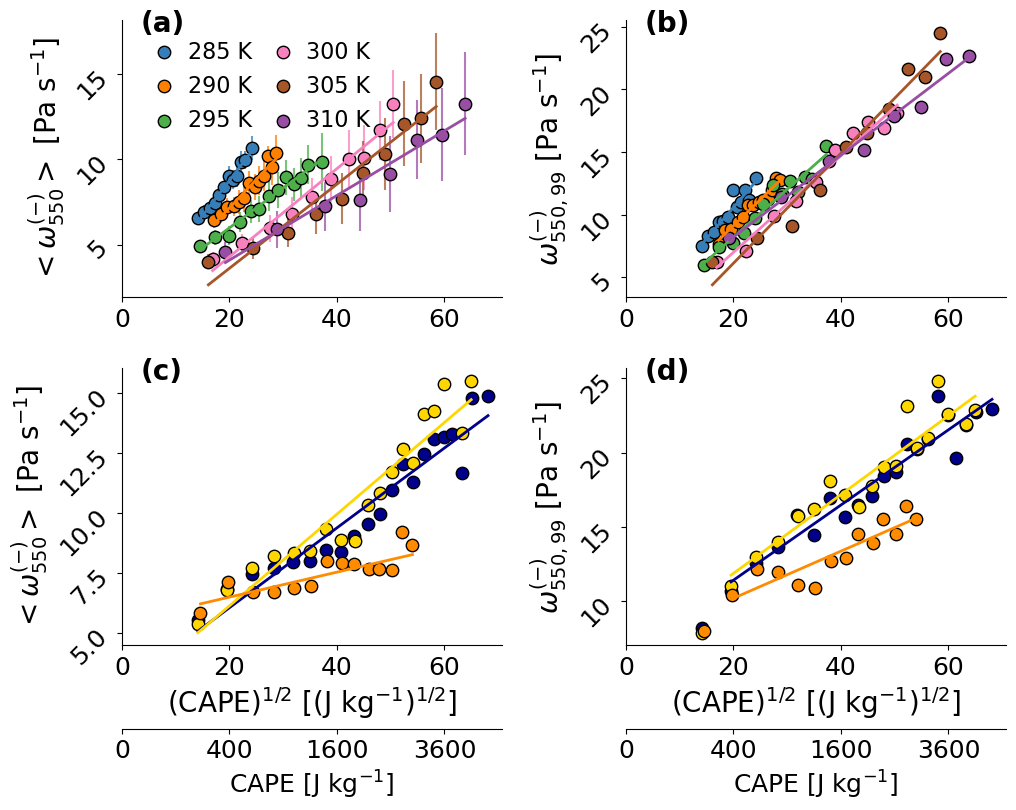

In [25]:
fig, ax = plt.subplots( 2, 2, figsize =(10.5, 8.5) )

ylab = [ r'$<\omega_{550}^{(-)}>$ [Pa s$^{-1}$]', r'$\omega_{550,99}^{(-)}$ [Pa s$^{-1}$]',
         r'$<\omega_{550}^{(-)}>$ [Pa s$^{-1}$]', r'$\omega_{550,99}^{(-)}$ [Pa s$^{-1}$]' ]
labels = [ '', '' , r'(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]', '(CAPE)$^{1/2}$ [(J kg$^{-1})^{1/2}$]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]
font_size = 18
sz = 80
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flatten()): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, np.sqrt(5000)] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    
    axis.text( 0.05, 0.96, let[i], weight='bold', fontsize=20, transform=axis.transAxes )
    if i == 0:
        for j, k, l, m in zip(cape_bins_list, ascent_list, np.arange(len(cape_bins_list)), ascent_error_list):
            axis.scatter( np.sqrt(j), k, color = CB_color_cycle[l], s=sz, edgecolor='black', label=str(ssts[l])+' K'  )
            axis.errorbar( np.sqrt(j), k, xerr=None, yerr=m/2, color = CB_color_cycle[l], ls='none', zorder=-1, alpha=0.75 )
            out, y_predicted, x_input = linindx( np.sqrt(j), k )
            axis.plot( x_input, y_predicted, color=CB_color_cycle[l], linewidth=2, zorder=10 )
        axis.legend( loc='upper left', ncol=2, frameon=False, fontsize=16, columnspacing=0.4, handletextpad=0.05 )
        
    elif i == 1:
        for j, k, l in zip(cape_bins_list, ascent_99_list, np.arange(len(cape_bins_list))):
            axis.scatter( np.sqrt(j), k, color = CB_color_cycle[l], s=sz, edgecolor='black' )
            out, y_predicted, x_input = linindx( np.sqrt(j), k )
            axis.plot( x_input, y_predicted, color=CB_color_cycle[l], linewidth=2, zorder=10 )
        
    elif i == 2:
        axis.scatter( np.sqrt(cape_bins_all), ascent_vals_all, s=sz, color='darkblue', edgecolor='k' )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_all), ascent_vals_all )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=2, zorder=10 )
        
        axis.scatter( np.sqrt(cape_bins_small), ascent_vals_small, s=sz, color='gold', edgecolor='k' )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_small), ascent_vals_small )
        axis.plot( x_input, y_predicted, color='gold', linewidth=2, zorder=10 )
        
        axis.scatter( np.sqrt(cape_bins_large), ascent_vals_large, s=sz, color='darkorange', edgecolor='k' )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_large), ascent_vals_large )
        axis.plot( x_input, y_predicted, color='darkorange', linewidth=2, zorder=10 )
        
        ax2 = axis.secondary_xaxis( -0.3, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 400, 1600, 3600] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )
        
    else:
        axis.scatter( np.sqrt(cape_bins_all), ascent99_vals_all, s=sz, color='darkblue', edgecolor='k' )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_all), ascent99_vals_all )
        axis.plot( x_input, y_predicted, color='darkblue', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_small), ascent99_vals_small, s=sz, color='gold', edgecolor='k' )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_small), ascent99_vals_small )
        axis.plot( x_input, y_predicted, color='gold', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue, out.pvalue)
        
        axis.scatter( np.sqrt(cape_bins_large), ascent99_vals_large, s=sz, color='darkorange', edgecolor='k' )
        out, y_predicted, x_input = linindx( np.sqrt(cape_bins_large), ascent99_vals_large )
        axis.plot( x_input, y_predicted, color='darkorange', linewidth=2, zorder=10 )
        print(out.slope, out.rvalue, out.pvalue)
                
        ax2 = axis.secondary_xaxis( -0.3, functions=(squared, sqrt) )
        ax2.set_xticks( [0, 400, 1600, 3600] )
        ax2.set_xlabel( r'CAPE [J kg$^{-1}$]', fontsize=font_size )
            
plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/cape-ascent-RCE.pdf', bbox_inches='tight' )
plt.show()